<a href="https://colab.research.google.com/github/lokasenna9312/AIFFEL_quest_cr/blob/main/20250214_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 라이브러리 소환

from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
# 분석할 파일 소환

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
!wget -P /content/ $_URL
!unzip -q cats_and_dogs_filtered.zip -d .

--2025-02-16 11:03:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.4MB/s    in 4.0s    

2025-02-16 11:03:06 (16.2 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
# 훈련, 검증 데이터 등록

path = '/content/cats_and_dogs_filtered/'
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/content/cats_and_dogs_filtered/train
/content/cats_and_dogs_filtered/validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/content/cats_and_dogs_filtered/train/cats
/content/cats_and_dogs_filtered/train/dogs
/content/cats_and_dogs_filtered/validation/cats
/content/cats_and_dogs_filtered/validation/dogs


In [5]:
# 각 사진의 갯수 확인 (강아지, 고양이 / 훈련, 검증)

num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [6]:
# 하이퍼파라미터 지정
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [7]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
# 주어진 사진들을 이용해서 훈련 데이터를 더 많이 생성
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [9]:
# 데이터 증강이 제대로 됐는지 확인

train_data_gen[0][0].shape

(16, 256, 256, 3)

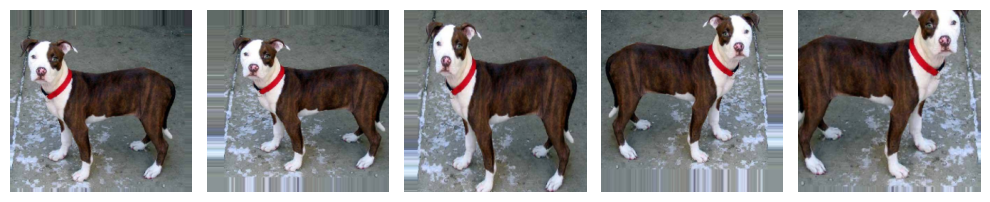

In [10]:
# 데이터 증강으로 만들어낸 훈련 이미지 보기

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [11]:
# 검증 데이터도 증강하기
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


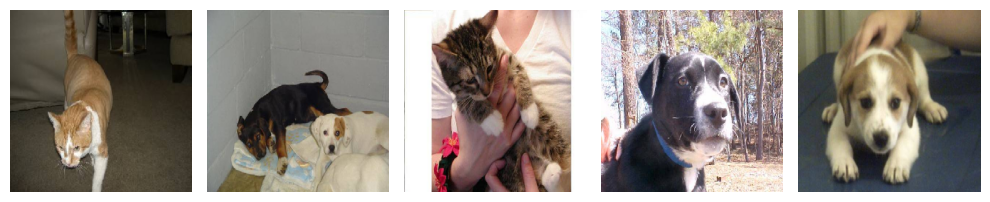

In [12]:
# 데이터 증강으로 만들어낸 검증 이미지 보기

sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [13]:
# 위의 각각의 이미지의 라벨 보기

_[:5]

array([0., 1., 0., 1., 1.], dtype=float32)

In [14]:
# 문제에 주어진 그림을 참고해서 더 작은 크기로 VGG 모델 구현하기
# 11단계에서 19단계까지를 생략하고, FC단계의 Dense Layer도 대폭 줄임. (LMS에서 실험한 버전보다도 훨씬 더 많이 줄임.)
# 활성화 함수는 문제의 그림에 적혀있는대로 softmax를 사용했는데 이것이 패인이었음.

input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
x=tf.keras.layers.Dense(500, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     134,218,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │         256,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,475,177 (520.61 MB)

 Trainable params: 136,474,281 (520.61 MB)

 Non-trainable params: 896 (3.50 KB)

In [15]:
# 모델 컴파일

loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

In [16]:
# 모델 훈련 실햄

history = model.fit(
      train_data_gen,
      steps_per_epoch=int((len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size),
      epochs=epochs,
      validation_data=val_data_gen,
      validation_freq=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 446ms/step - binary_accuracy: 0.5151 - loss: 214.8569 - val_binary_accuracy: 0.5000 - val_loss: 1.3462
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 362ms/step - binary_accuracy: 0.4986 - loss: 0.7616 - val_binary_accuracy: 0.5000 - val_loss: 0.7050
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 367ms/step - binary_accuracy: 0.4889 - loss: 0.7235 - val_binary_accuracy: 0.5000 - val_loss: 0.6938
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 363ms/step - binary_accuracy: 0.4924 - loss: 0.7266 - val_binary_accuracy: 0.5000 - val_loss: 1.3291
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 363ms/step - binary_accuracy: 0.5112 - loss: 0.8095 - val_binary_accuracy: 0.5000 - val_loss: 0.7018


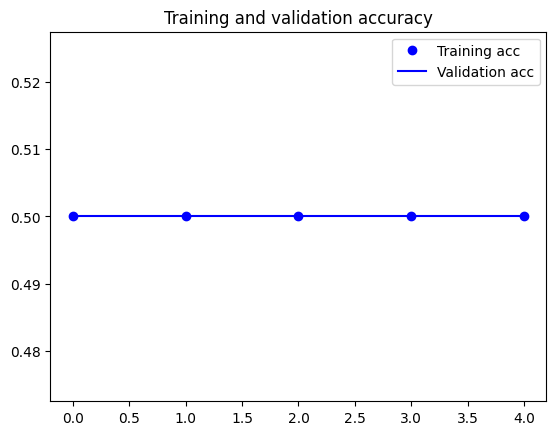

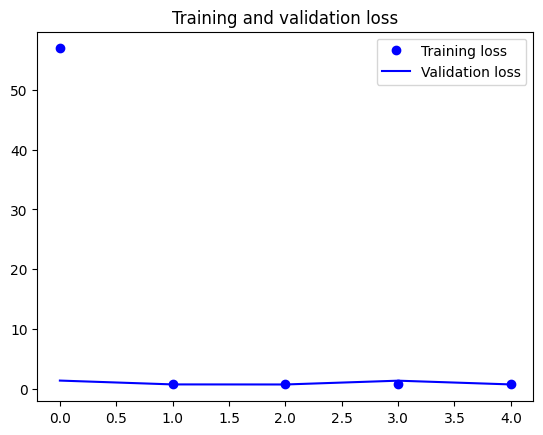

In [18]:
# 정확도와 손실을 그래프로 그려보기

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 첫 epoch에서의 손실이 매우 컸고 accurascy가 모두 0.5 근방에서 노는, 특히 검증 데이터의 accuracy는 정확히 0.5만을 띄우는 문제가 있었다.

In [19]:
# hyperparameter를 재설정해보았다. 정확히는 epocc 횟수를 10회로 늘렸다.

batch_size = 16
epochs = 10
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [20]:
# rotation range와 shift range, zoom range를 늘려보았다.
# rotaion range는 1.0으로, 나머지 range는 2배씩 늘렸다.

image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=1.0,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.4,
                                     horizontal_flip=True,
                                     vertical_flip=False)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
#활성화 함수를 softmax에서 sigmoid로 바꿔보았다.
#레이어의 갯수나 컨볼루션의 횟수를 늘리는 건 lms의 연산능력이 부족해서 불가능했으므로...

input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
x=tf.keras.layers.Dense(500, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │     134,218,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 500)                 │         256,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,475,177 (520.61 MB)

 Trainable params: 136,474,281 (520.61 MB)

 Non-trainable params: 896 (3.50 KB)

In [22]:
#옵티마이저의 learning rate를 0.005로 줄여보았다,

loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.005)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

In [23]:
#다시 훈련 실행.

history = model.fit(
      train_data_gen,
      steps_per_epoch=int((len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size),
      epochs=epochs,
      validation_data=val_data_gen,
      validation_freq=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_19']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 370ms/step - binary_accuracy: 0.5209 - loss: 40.2851 - val_binary_accuracy: 0.5050 - val_loss: 1.3671
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 360ms/step - binary_accuracy: 0.5656 - loss: 0.7575 - val_binary_accuracy: 0.4990 - val_loss: 0.7195
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 376ms/step - binary_accuracy: 0.5223 - loss: 0.7182 - val_binary_accuracy: 0.5610 - val_loss: 0.6828
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 360ms/step - binary_accuracy: 0.5646 - loss: 0.6867 - val_binary_accuracy: 0.5640 - val_loss: 0.6876
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 361ms/step - binary_accuracy: 0.5206 - loss: 0.6944 - val_binary_accuracy: 0.5350 - val_loss: 0.6848
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 363ms/step - binary_accuracy: 0.5462 - loss: 0.6881 - val_binary_accuracy: 0.5390 - val_loss: 0.6867
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 363ms/step - binary_accuracy: 0.5531 - loss: 0.6786 - val_binary_accuracy: 0.5600 - val_loss: 0.

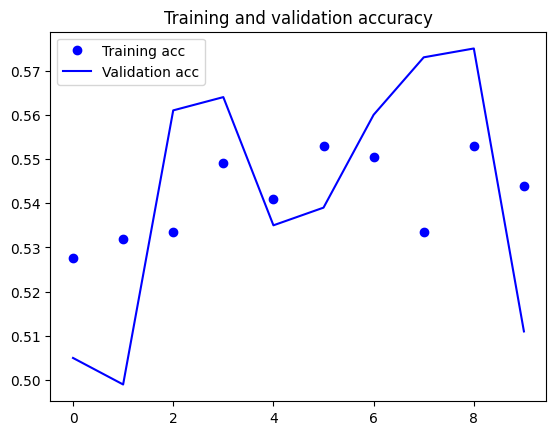

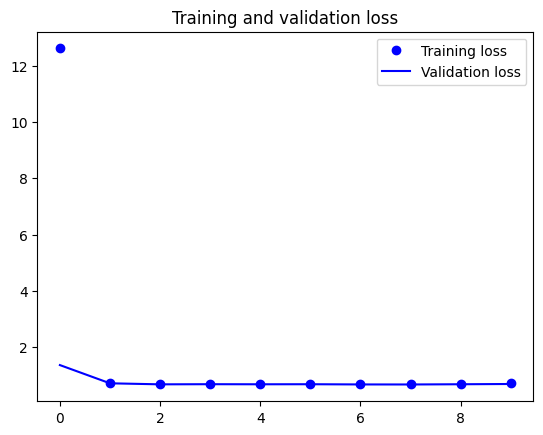

In [24]:
# 정확도와 손실을 그래프로 그려보기

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Training Accuracy는 꾸준히 증가하는 모양새를 보이고 있고, Validation Accuracy 역시 0.5 밑으로 떨어지지 않고 있다.
# 첫 Validation Loss 역시 위의 실험에 비교했을 때 많이 줄었다. learning rate를 줄 영향인지.